In [1]:
import subprocess; result = subprocess.run(['pip3', 'install', 'ipython-autotime'], capture_output=True)
print(f"There was a problem installing the package.\nError output:\n{result.stderr.decode('utf-8')}") if result.returncode != 0 else print("Package installed successfully.")


Package installed successfully.


In [2]:
%load_ext autotime


time: 148 µs (started: 2024-04-08 12:05:27 -07:00)


In [3]:
# !pip3 install xgboost

time: 118 µs (started: 2024-04-08 12:05:27 -07:00)


In [4]:
import sys
# source_directory = "/opt/homebrew/bin"
# sys.path.append(source_directory)

# source_directory = "/opt/homebrew/Cellar"
# sys.path.append(source_directory)

import sys
source_directory = "/Users/pauljacob/Library/Python/3.9/lib/python/site-packages"
sys.path.append(source_directory)

time: 367 µs (started: 2024-04-08 12:05:27 -07:00)


In [5]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, ClassifierMixin

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

time: 1.79 s (started: 2024-04-08 12:05:27 -07:00)


In [6]:
import time


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99.9% !important; }</style>"))
pd.options.display.max_columns = 3999
pd.options.display.max_rows = 999

pd.set_option('display.max_colwidth', None)
pd.options.display.max_info_columns = 3999


###########################

def preview_list(list_):
    """Print the list length and return the list.

    Args:
        list_ (list): The list object to return.

    Returns:
        list_ (list): The same list object.
    """
    print(len(list_))
    return list_

/var/folders/77/y4hv4_s9751293nzv4yrfrtm0000gn/T/ipykernel_45801/3797286981.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


time: 2.9 ms (started: 2024-04-08 12:05:29 -07:00)


### Pre-Fitted Voting Model

In [7]:
class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

time: 658 µs (started: 2024-04-08 12:05:29 -07:00)


### Pipeline

### Automatic Aggregation

### File I/O

### Feature Engineering

### Configuration

### Train Files Read & Feature Engineering

In [8]:
import pandas as pd

def drop_null_columns(df, threshold=0.95):
    null_threshold = threshold * len(df)
    
    columns_to_drop = [col for col in df.columns if df[col].isnull().sum() > null_threshold]
    
    df = df.drop(columns=columns_to_drop)
    
    return df


time: 395 µs (started: 2024-04-08 12:05:29 -07:00)


## Overhaul 3: to_datetime() more

In [9]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df.loc[:, col] = df.loc[:, col].astype('int32')
            elif col in ["date_decision"]:
                df.loc[:, col] = pd.to_datetime(df.loc[:, col]) #.astype('datetime64[ns]') #with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df.loc[:, col] = df.loc[:, col].astype('float64') #with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df.loc[:, col] = df.loc[:, col].astype('object') #.astype('string') #with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df.loc[:, col] = pd.to_datetime(df.loc[:, col]) #.astype('datetime64[ns]') #with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        '''Edit date to number of days before the loan approval/refusal/denial decision date'''
        for col in df.columns:
            if col[-1] in ("D",):
                df.loc[:, col] = df.loc[:, col] - df.loc[:, 'date_decision'] #.with_columns(pl.col(col) - pl.col("date_decision"))
                df.loc[:, col] = df.loc[:, col].astype('timedelta64[D]') #df = df.with_columns(pl.col(col).dt.total_days())
                #with_columns(pl.col(col).cast(pl.Float32))
                
        return df.drop(columns=["date_decision", "MONTH"])

    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].isnull().mean()

                if isnull > 0.95:
                    df = df.drop(columns=col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == object):
                freq = df[col].nunique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(columns=col)

        return df



class Aggregator:
    @staticmethod
    def num_expr(df):
        '''P is for Transform DPD (Days past due); A is for Transform amount'''
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        return {col:'max' for col in cols}
   

    @staticmethod
    def date_expr(df):
        '''D is for Transform date'''
        cols = [col for col in df.columns if col[-1] in ("D",)]

        return {col:'max' for col in cols}

    @staticmethod
    def str_expr(df):
        '''M is for  Masking categories'''
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        return {col:'max' for col in cols}

    @staticmethod
    def other_expr(df):
        '''T is for Unspecified Transform; L is for Unspecified Transform'''
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        return {col:'max' for col in cols}

    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        return {col:'max' for col in cols}
        

    @staticmethod
    def get_exprs(df):
        return {**Aggregator.num_expr(df),
                **Aggregator.date_expr(df), 
                #**Aggregator.str_expr(df), 
                #**Aggregator.other_expr(df),
                **Aggregator.count_expr(df)}

    
    @staticmethod    
    def get_cols_dictionary(df):
        exprs = Aggregator.get_exprs(df)
        cols = exprs.keys()
        cols_dictionary = {f'{col}':f'{exprs[col]}_{col}' for col in cols}
#         print(f"cols_dictionary: {cols_dictionary}")
        return cols_dictionary

    
    

def read_file(path, depth=None):
    '''read in the file; the data type by column name or suffix'''
    df = pd.read_csv(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.groupby("case_id").agg(Aggregator.get_exprs(df)).rename(columns=Aggregator.get_cols_dictionary(df)) #df = df.groupby("case_id").agg(Aggregator.get_exprs(df))
    
    return df


def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        df = pd.read_csv(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        
        if depth in [1, 2]:
            df = df.groupby("case_id").agg(Aggregator.get_exprs(df)).rename(columns=Aggregator.get_cols_dictionary(df))

        
        chunks.append(df)
        
    df = pd.concat(chunks, axis=0)
    return df.drop_duplicates()





def feature_engineering(df_base, depth_0, depth_1, depth_2):
    
    #add 2 new columns
    df_base.loc[:, 'date_decision'] = pd.to_datetime(df_base.loc[:, 'date_decision'])
    df_base.loc[:, 'month_decision'] = df_base.loc[:, 'date_decision'].dt.month
    df_base.loc[:, 'day_decision'] = df_base.loc[:, 'date_decision'].dt.day
    #df_base = (df_base.with_columns(month_decision = pl.col("date_decision").dt.month(), weekday_decision = pl.col("date_decision").dt.weekday(),))

    
    #left join the DataFrame's in the list on 'case_id'
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = pd.merge(df_base, df, on='case_id', how='left', suffixes=("", f"_{i}")) #df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base




TRAIN_DIR = "../data/raw/train/"

data_store = {
    "df_base": read_file(TRAIN_DIR + "train_base.csv"),
    "depth_0": [
        read_file(TRAIN_DIR + "train_static_cb_0.csv"),
        read_files(TRAIN_DIR + "train_static_0_*.csv"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR + "train_applprev_1_*.csv", 1),
        read_file(TRAIN_DIR + "train_tax_registry_a_1.csv", 1),
        read_file(TRAIN_DIR + "train_tax_registry_b_1.csv", 1),
        read_file(TRAIN_DIR + "train_tax_registry_c_1.csv", 1),
        read_files(TRAIN_DIR + "train_credit_bureau_a_1_*.csv", 1),
        read_file(TRAIN_DIR + "train_credit_bureau_b_1.csv", 1),
        read_file(TRAIN_DIR + "train_other_1.csv", 1),
        read_file(TRAIN_DIR + "train_person_1.csv", 1),
        read_file(TRAIN_DIR + "train_deposit_1.csv", 1),
        read_file(TRAIN_DIR + "train_debitcard_1.csv", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR + "train_credit_bureau_b_2.csv", 2),
        read_files(TRAIN_DIR + "train_credit_bureau_a_2_*.csv", 2),
    ]
}



def preview_df(df):
    """Of this DataFrame, prints the row and column count and then returns the concatenated first 5 and last % rows.

    Args:
        df (DataFrame): This pandas DataFrame object.
    Returns:
        df (DataFrame): The concatenated first 5 and last 5 rows of this pandas DataFrame.
    """
    if df.shape[0] > 9:
        print(df.shape)
        return pd.DataFrame(pd.concat([df.head(5), df.tail(5)]))
    else:
        return df

    
#The *args will give you all positional arguments as a tuple
#The **kwargs will give you all keyword arguments as a dictionary

df_train = feature_engineering(**data_store)

del data_store

preview_df(df_train)



/var/folders/77/y4hv4_s9751293nzv4yrfrtm0000gn/T/ipykernel_45801/3164545557.py:110: DtypeWarning: Columns (1,2,3,4,7,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/var/folders/77/y4hv4_s9751293nzv4yrfrtm0000gn/T/ipykernel_45801/3164545557.py:122: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/var/folders/77/y4hv4_s9751293nzv4yrfrtm0000gn/T/ipykernel_45801/3164545557.py:122: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/var/folders/77/y4hv4_s9751293nzv4yrfrtm0000gn/T/ipykernel_45801/3164545557.py:122: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


cols_dictionary: {'actualdpd_943P': 'max_actualdpd_943P', 'annuity_853A': 'max_annuity_853A', 'credacc_actualbalance_314A': 'max_credacc_actualbalance_314A', 'credacc_credlmt_575A': 'max_credacc_credlmt_575A', 'credacc_maxhisbal_375A': 'max_credacc_maxhisbal_375A', 'credacc_minhisbal_90A': 'max_credacc_minhisbal_90A', 'credamount_590A': 'max_credamount_590A', 'currdebt_94A': 'max_currdebt_94A', 'downpmt_134A': 'max_downpmt_134A', 'mainoccupationinc_437A': 'max_mainoccupationinc_437A', 'maxdpdtolerance_577P': 'max_maxdpdtolerance_577P', 'outstandingdebt_522A': 'max_outstandingdebt_522A', 'revolvingaccount_394A': 'max_revolvingaccount_394A', 'approvaldate_319D': 'max_approvaldate_319D', 'creationdate_885D': 'max_creationdate_885D', 'dateactivated_425D': 'max_dateactivated_425D', 'dtlastpmt_581D': 'max_dtlastpmt_581D', 'dtlastpmtallstes_3545839D': 'max_dtlastpmtallstes_3545839D', 'employedfrom_700D': 'max_employedfrom_700D', 'firstnonzeroinstldate_307D': 'max_firstnonzeroinstldate_307D', 

/var/folders/77/y4hv4_s9751293nzv4yrfrtm0000gn/T/ipykernel_45801/3164545557.py:122: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


cols_dictionary: {'actualdpd_943P': 'max_actualdpd_943P', 'annuity_853A': 'max_annuity_853A', 'credacc_actualbalance_314A': 'max_credacc_actualbalance_314A', 'credacc_credlmt_575A': 'max_credacc_credlmt_575A', 'credacc_maxhisbal_375A': 'max_credacc_maxhisbal_375A', 'credacc_minhisbal_90A': 'max_credacc_minhisbal_90A', 'credamount_590A': 'max_credamount_590A', 'currdebt_94A': 'max_currdebt_94A', 'downpmt_134A': 'max_downpmt_134A', 'mainoccupationinc_437A': 'max_mainoccupationinc_437A', 'maxdpdtolerance_577P': 'max_maxdpdtolerance_577P', 'outstandingdebt_522A': 'max_outstandingdebt_522A', 'revolvingaccount_394A': 'max_revolvingaccount_394A', 'approvaldate_319D': 'max_approvaldate_319D', 'creationdate_885D': 'max_creationdate_885D', 'dateactivated_425D': 'max_dateactivated_425D', 'dtlastpmt_581D': 'max_dtlastpmt_581D', 'dtlastpmtallstes_3545839D': 'max_dtlastpmtallstes_3545839D', 'employedfrom_700D': 'max_employedfrom_700D', 'firstnonzeroinstldate_307D': 'max_firstnonzeroinstldate_307D', 

/var/folders/77/y4hv4_s9751293nzv4yrfrtm0000gn/T/ipykernel_45801/3164545557.py:122: DtypeWarning: Columns (11,12,14,30,44,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


cols_dictionary: {'credlmt_230A': 'max_credlmt_230A', 'credlmt_935A': 'max_credlmt_935A', 'debtoutstand_525A': 'max_debtoutstand_525A', 'debtoverdue_47A': 'max_debtoverdue_47A', 'dpdmax_139P': 'max_dpdmax_139P', 'dpdmax_757P': 'max_dpdmax_757P', 'instlamount_768A': 'max_instlamount_768A', 'instlamount_852A': 'max_instlamount_852A', 'monthlyinstlamount_332A': 'max_monthlyinstlamount_332A', 'monthlyinstlamount_674A': 'max_monthlyinstlamount_674A', 'outstandingamount_354A': 'max_outstandingamount_354A', 'outstandingamount_362A': 'max_outstandingamount_362A', 'overdueamount_31A': 'max_overdueamount_31A', 'overdueamount_659A': 'max_overdueamount_659A', 'overdueamountmax2_14A': 'max_overdueamountmax2_14A', 'overdueamountmax2_398A': 'max_overdueamountmax2_398A', 'overdueamountmax_155A': 'max_overdueamountmax_155A', 'overdueamountmax_35A': 'max_overdueamountmax_35A', 'residualamount_488A': 'max_residualamount_488A', 'residualamount_856A': 'max_residualamount_856A', 'totalamount_6A': 'max_total

/var/folders/77/y4hv4_s9751293nzv4yrfrtm0000gn/T/ipykernel_45801/3164545557.py:110: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


cols_dictionary: {'amount_1115A': 'max_amount_1115A', 'credlmt_1052A': 'max_credlmt_1052A', 'credlmt_228A': 'max_credlmt_228A', 'credlmt_3940954A': 'max_credlmt_3940954A', 'debtpastduevalue_732A': 'max_debtpastduevalue_732A', 'debtvalue_227A': 'max_debtvalue_227A', 'dpd_550P': 'max_dpd_550P', 'dpd_733P': 'max_dpd_733P', 'dpdmax_851P': 'max_dpdmax_851P', 'installmentamount_644A': 'max_installmentamount_644A', 'installmentamount_833A': 'max_installmentamount_833A', 'instlamount_892A': 'max_instlamount_892A', 'maxdebtpduevalodued_3940955A': 'max_maxdebtpduevalodued_3940955A', 'overdueamountmax_950A': 'max_overdueamountmax_950A', 'pmtdaysoverdue_1135P': 'max_pmtdaysoverdue_1135P', 'residualamount_1093A': 'max_residualamount_1093A', 'residualamount_127A': 'max_residualamount_127A', 'residualamount_3940956A': 'max_residualamount_3940956A', 'totalamount_503A': 'max_totalamount_503A', 'totalamount_881A': 'max_totalamount_881A', 'contractdate_551D': 'max_contractdate_551D', 'contractmaturitydat

/var/folders/77/y4hv4_s9751293nzv4yrfrtm0000gn/T/ipykernel_45801/3164545557.py:110: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


cols_dictionary: {'mainoccupationinc_384A': 'max_mainoccupationinc_384A', 'birth_259D': 'max_birth_259D', 'birthdate_87D': 'max_birthdate_87D', 'empl_employedfrom_271D': 'max_empl_employedfrom_271D', 'num_group1': 'max_num_group1'}
cols_dictionary: {'amount_416A': 'max_amount_416A', 'contractenddate_991D': 'max_contractenddate_991D', 'openingdate_313D': 'max_openingdate_313D', 'num_group1': 'max_num_group1'}
cols_dictionary: {'last180dayaveragebalance_704A': 'max_last180dayaveragebalance_704A', 'last180dayturnover_1134A': 'max_last180dayturnover_1134A', 'last30dayturnover_651A': 'max_last30dayturnover_651A', 'openingdate_857D': 'max_openingdate_857D', 'num_group1': 'max_num_group1'}
cols_dictionary: {'pmts_dpdvalue_108P': 'max_pmts_dpdvalue_108P', 'pmts_pmtsoverdue_635A': 'max_pmts_pmtsoverdue_635A', 'pmts_date_1107D': 'max_pmts_date_1107D', 'num_group1': 'max_num_group1', 'num_group2': 'max_num_group2'}
cols_dictionary: {'pmts_dpd_1073P': 'max_pmts_dpd_1073P', 'pmts_dpd_303P': 'max_pm

,case_id,WEEK_NUM,target,month_decision,day_decision,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,foryear_850L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,equalityempfrom_62L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,interestrategrace_34L,isbidproduct_1095L,isbidproductrequest_292L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastdependentsnum_448L,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastrepayingdate_696D,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxannuity_4075009A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_

time: 14min 24s (started: 2024-04-08 12:05:29 -07:00)


In [ ]:
#^---- time: 14min 24s (started: 2024-04-08 12:05:29 -07:00)


In [10]:
# help(gc.collect)

Help on built-in function collect in module gc:

collect(generation=2)
    Run the garbage collector.
    
    With no arguments, run a full collection.  The optional argument
    may be an integer specifying which generation to collect.  A ValueError
    is raised if the generation number is invalid.
    
    The number of unreachable objects is returned.

time: 9.69 ms (started: 2024-04-08 12:19:54 -07:00)


In [11]:
gc.collect()

6795

time: 14.1 s (started: 2024-04-08 12:19:54 -07:00)


### Feature Elimination

In [12]:
#drop columns with more than 95% non-null values

df_train = df_train.pipe(Pipeline.filter_cols)

preview_df(df_train)


(1526659, 269)


,case_id,WEEK_NUM,target,month_decision,day_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,validfrom_1069D,max_actualdpd_943P,max_annuity_853A,max_credacc_

time: 3min 18s (started: 2024-04-08 12:20:08 -07:00)


In [13]:
#M,T,L: M - masked, T - unspecified transformed, L unspecified transform

#masked is expected as object

#T would need investigation

#L would need investigation


column_name_list = list(df_train.columns)
column_name_list_suffix_L = [column_name for column_name in column_name_list if column_name[-1] == 'L']
df_suffix_L = df_train.loc[:, column_name_list_suffix_L]
preview_df(df_suffix_L)

(1526659, 96)


,contractssum_5085716L,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,firstquarter_103L,fourthquarter_440L,numberofqueries_373L,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,requesttype_4525192L,secondquarter_766L,thirdquarter_1082L,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credtype_322L,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursementtype_67L,eir_270L,equalitydataagreement_891L,homephncnt_628L,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,lastst_736L,mastercontrelectronic_519L,mastercontrexist_109L,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,sellerplacecnt_915L,sellerplacescnt_216L,twobodfilling_608L
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,CAL,NaN,0.0,GBA,0.4500,NaN,0.0,CASH,0.4500,False,NaN,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,0.0,0.0,BO
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,CAL,NaN,0.0,GBA,0.2999,NaN,0.0,CASH,0.2999,False,NaN,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,0.0,0.0,BO
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,CAL,NaN,0.0,GBA,0.4500,NaN,1.0,CASH,0.4500,False,D,0.0,0.0,2.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,36.0,0.0,0.0,BO
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,CAL,NaN,0.0,GBA,0.4200,True,0.0,CASH,0.4200,False,D,0.0,0.0,1.0,NaN,0.0,0.0,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,False,NaN,NaN,NaN,NaN,NaN,12.0,1.0,1.0,BO
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,CAL,NaN,0.0,GBA,0.4500,NaN,1.0,CASH,0.4500,False,T,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,Na

time: 548 ms (started: 2024-04-08 12:23:26 -07:00)


In [14]:
#use assumption of good interpretation of data types by pandas
column_name_list_L_int = list(df_suffix_L.select_dtypes(include=['int']).columns)
column_name_list_L_float = list(df_suffix_L.select_dtypes(include=['float']).columns)
column_name_list_L_object = list(df_suffix_L.select_dtypes(include=['object']).columns)
column_name_list_L_bool = list(df_suffix_L.select_dtypes(include=['bool']).columns)


time: 945 µs (started: 2024-04-08 12:23:27 -07:00)


In [15]:
preview_df(df_suffix_L.loc[:, column_name_list_L_object])

,requesttype_4525192L,cardtype_51L,credtype_322L,disbursementtype_67L,equalitydataagreement_891L,inittransactioncode_186L,lastst_736L,opencred_647L,twobodfilling_608L
0,NaN,NaN,CAL,GBA,NaN,CASH,NaN,NaN,BO
1,NaN,NaN,CAL,GBA,NaN,CASH,NaN,NaN,BO
2,NaN,NaN,CAL,GBA,NaN,CASH,D,False,BO
3,NaN,NaN,CAL,GBA,True,CASH,D,False,BO
4,NaN,NaN,CAL,GBA,NaN,CASH,T,False,BO
...,...,...,...,...,...,...,...,...,...
1526654,NaN,NaN,CAL,GBA,NaN,CASH,K,False,FO
1526655,NaN,NaN,CAL,GBA,NaN,CASH,A,False,FO
1526656,NaN,NaN,CAL,GBA,NaN,CASH,T,False,BO
1526657,NaN,NaN,CAL,GBA,NaN,CASH,A,False,BO


time: 87.9 ms (started: 2024-04-08 12:23:27 -07:00)


In [16]:
column_name_list_suffix_M = [column_name for column_name in column_name_list if column_name[-1] == 'M' and not column_name=='WEEK_NUM']
df_suffix_M=df_train.loc[:, column_name_list_suffix_M]
preview_df(df_suffix_M)

(1526659, 11)


,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,lastapprcommoditycat_1041M,lastcancelreason_561M,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectreason_759M,lastrejectreasonclient_4145040M
0,NaN,NaN,NaN,NaN,NaN,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
1,NaN,NaN,NaN,NaN,NaN,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
2,NaN,NaN,NaN,NaN,NaN,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
3,NaN,NaN,NaN,NaN,NaN,a55475b1,P94_109_143,a55475b1,a55475b1,P94_109_143,a55475b1
4,NaN,NaN,NaN,NaN,NaN,a55475b1,P24_27_36,a55475b1,a55475b1,a55475b1,a55475b1
1526654,2fc785b2,a55475b1,a55475b1,a55475b1,a55475b1,P12_6_178,a55475b1,a55475b1,a55475b1,P94_109_143,P94_109_143
1526655,2fc785b2,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
1526656,2fc785b2,a55475b1,a55475b1,a55475b1,a55475b1,P159_130_59,P180_60_137,a55475b1,a55475b1,a55475b1,a55475b1
1526657,2fc785b2,6b2ae0fa,a55475b1,3439d993,a55475b1,a55475b1,a55475b1,P159_130_59,P174_113_42,a55475b1,a55475b1
1526658,2fc785b2,a55475b1,a55475b1,b6cabe76,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1


time: 102 ms (started: 2024-04-08 12:23:27 -07:00)


In [17]:
column_name_drop_list = []

#drop masked features for now
column_name_drop_list += ['description_5085714M', 'education_1103M', 'education_88M', 'maritalst_385M', 'maritalst_893M', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastcancelreason_561M', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'previouscontdistrict_112M']
preview_list(column_name_drop_list)



13


['description_5085714M',
 'education_1103M',
 'education_88M',
 'maritalst_385M',
 'maritalst_893M',
 'lastapprcommoditycat_1041M',
 'lastapprcommoditytypec_5251766M',
 'lastcancelreason_561M',
 'lastrejectcommoditycat_161M',
 'lastrejectcommodtypec_5251769M',
 'lastrejectreason_759M',
 'lastrejectreasonclient_4145040M',
 'previouscontdistrict_112M']

time: 1.59 ms (started: 2024-04-08 12:23:27 -07:00)


In [18]:
# df_train.info(show_counts=True)

time: 151 µs (started: 2024-04-08 12:23:27 -07:00)


### Convert to Type 'category' from Type 'object'

In [19]:
#def to_pandas(df_data, cat_cols=None):
def df_object_to_category(df_data, cat_cols=None):
    #df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

df_train, cat_cols = df_object_to_category(df_train)


time: 3.73 s (started: 2024-04-08 12:23:27 -07:00)


In [138]:

# TRAIN_DIR = "../data/raw/train/"
# #df = read_files2(TRAIN_DIR + "train_applprev_1_0.csv", 1)
# df = read_files2(TRAIN_DIR + "train_applprev_1_*.csv", 1)
# preview_df(df)





time: 1.81 ms (started: 2024-04-08 21:10:10 -07:00)


### EDA

Train is duplicated:	 False
Train Week Range:	 (0, 91)


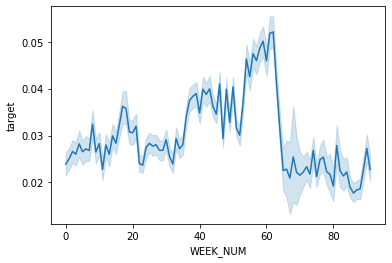

time: 12 s (started: 2024-04-08 12:23:59 -07:00)


In [21]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any())
print("Train Week Range:\t", (df_train["WEEK_NUM"].min(), df_train["WEEK_NUM"].max()))

sns.lineplot(data=df_train, x="WEEK_NUM", y="target",)
plt.show()

In [22]:
!pip3 install -U xgboost

python(46340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


time: 3.36 s (started: 2024-04-08 12:24:11 -07:00)


In [23]:
import xgboost as xgb
from xgboost import XGBClassifier


print(xgb.__version__)

2.0.3
time: 51.2 ms (started: 2024-04-08 12:24:15 -07:00)


In [24]:
# X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
# y = df_train["target"]
# weeks = df_train["WEEK_NUM"]

# cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

# params = {
#     "boosting_type": "gbdt",
#     "objective": "binary",
#     "metric": "auc",
#     "max_depth": 8,
#     "learning_rate": 0.05,
#     "n_estimators": 1000,
#     "colsample_bytree": 0.8, 
#     "colsample_bynode": 0.8,
#     "verbose": -1,
#     "random_state": 42,
#     "device": "gpu",
# }

# fitted_models = []

# for idx_train, idx_valid in cv.split(X, y, groups=weeks):
#     X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
#     X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

#     model = lgb.LGBMClassifier(**params)
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_valid, y_valid)],
#         callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
#     )

#     fitted_models.append(model)

# model = VotingModel(fitted_models)


time: 460 µs (started: 2024-04-08 12:24:15 -07:00)


In [25]:
X_train = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y_train = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

# params = {
#     "boosting_type": "gbdt",
#     "objective": "binary",
#     "metric": "auc",
#     "max_depth": 8,
#     "learning_rate": 0.05,
#     "n_estimators": 1000,
#     "colsample_bytree": 0.8, 
#     "colsample_bynode": 0.8,
#     "verbose": -1,
#     "random_state": 42,
#     "device": "gpu",
# }

# fitted_models = []

# for idx_train, idx_valid in cv.split(X, y, groups=weeks):
#     X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
#     X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

#     model = lgb.LGBMClassifier(**params)
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_valid, y_valid)],
#         callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
#     )

#     fitted_models.append(model)

# model = VotingModel(fitted_models)


time: 1.52 s (started: 2024-04-08 12:24:15 -07:00)


In [26]:

# from sklearn.model_selection import train_test_split
# data = load_iris()
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2)

# bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

# bst.fit(X_train, y_train)

# preds = bst.predict(X_test)

time: 261 µs (started: 2024-04-08 12:24:16 -07:00)


In [27]:
from sklearn.model_selection import train_test_split

df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
train_cols = [c for c in df_train.columns if c not in ("case_id", "date_decision", "target")]
X_train, X_valid, y_train, y_valid = train_test_split(
    df_train[train_cols], df_train['target'], test_size=0.2)

time: 5.29 s (started: 2024-04-08 12:24:16 -07:00)


In [29]:
#Source: https://xgboost.readthedocs.io/en/stable/parameter.html

model = xgb.XGBClassifier(
    device="cpu",
    objective='binary:logistic',
    enable_categorical=True,
    eval_metric='auc',
    #learning_rate=0.05,
    subsample=1,
    colsample_bytree=1,
    min_child_weight=1,
    #gamma=0.7,
    #reg_alpha=0.7,
    max_depth=20,
    n_estimators=20,
    random_state=42,
)

# Training the model on the training data
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=5,verbose=True,)

print(model)

/Users/pauljacob/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71618
[1]	validation_0-auc:0.74469
[2]	validation_0-auc:0.75941
[3]	validation_0-auc:0.76739
[4]	validation_0-auc:0.77352
[5]	validation_0-auc:0.77725
[6]	validation_0-auc:0.78069
[7]	validation_0-auc:0.78338
[8]	validation_0-auc:0.78710
[9]	validation_0-auc:0.78976
[10]	validation_0-auc:0.79189
[11]	validation_0-auc:0.79528
[12]	validation_0-auc:0.79697
[13]	validation_0-auc:0.79864
[14]	validation_0-auc:0.79995
[15]	validation_0-auc:0.80123
[16]	validation_0-auc:0.80261
[17]	validation_0-auc:0.80289
[18]	validation_0-auc:0.80320
[19]	validation_0-auc:0.80373
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device='cpu', early_stopping_rounds=None, enable_categorical=True,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_

In [ ]:
#^--- time: 7min 21s (started: 2024-04-08 12:25:19 -07:00)
#20 estimaters

In [30]:
#Source: https://xgboost.readthedocs.io/en/stable/parameter.html

model = xgb.XGBClassifier(
    device="cpu",
    objective='binary:logistic',
    enable_categorical=True,
    eval_metric='auc',
    #learning_rate=0.05,
    subsample=1,
    colsample_bytree=1,
    min_child_weight=1,
    #gamma=0.7,
    #reg_alpha=0.7,
    max_depth=20,
    n_estimators=40,
    random_state=42,
)

# Training the model on the training data
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=5,verbose=True,)

print(model)

/Users/pauljacob/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71618
[1]	validation_0-auc:0.74469
[2]	validation_0-auc:0.75941
[3]	validation_0-auc:0.76739
[4]	validation_0-auc:0.77352
[5]	validation_0-auc:0.77725
[6]	validation_0-auc:0.78069
[7]	validation_0-auc:0.78338
[8]	validation_0-auc:0.78710
[9]	validation_0-auc:0.78976
[10]	validation_0-auc:0.79189
[11]	validation_0-auc:0.79528
[12]	validation_0-auc:0.79697
[13]	validation_0-auc:0.79864
[14]	validation_0-auc:0.79995
[15]	validation_0-auc:0.80123
[16]	validation_0-auc:0.80261
[17]	validation_0-auc:0.80289
[18]	validation_0-auc:0.80320
[19]	validation_0-auc:0.80373
[20]	validation_0-auc:0.80456
[21]	validation_0-auc:0.80471
[22]	validation_0-auc:0.80496
[23]	validation_0-auc:0.80532
[24]	validation_0-auc:0.80563
[25]	validation_0-auc:0.80616
[26]	validation_0-auc:0.80615
[27]	validation_0-auc:0.80612
[28]	validation_0-auc:0.80652
[29]	validation_0-auc:0.80673
[30]	validation_0-auc:0.80637
[31]	validation_0-auc:0.80651
[32]	validation_0-auc:0.80686
[33]	validation_0-au

In [ ]:
#^----- 
#40 estimaters
#time: 11min 27s (started: 2024-04-08 12:34:20 -07:00)


In [31]:
#Source: https://xgboost.readthedocs.io/en/stable/parameter.html

model = xgb.XGBClassifier(
    device="cpu",
    objective='binary:logistic',
    enable_categorical=True,
    eval_metric='auc',
    #learning_rate=0.05,
    subsample=1,
    colsample_bytree=1,
    min_child_weight=1,
    #gamma=0.7,
    #reg_alpha=0.7,
    max_depth=20,
    n_estimators=80,
    random_state=42,
)

# Training the model on the training data
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=5,verbose=True,)

print(model)

/Users/pauljacob/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71618
[1]	validation_0-auc:0.74469
[2]	validation_0-auc:0.75941
[3]	validation_0-auc:0.76739
[4]	validation_0-auc:0.77352
[5]	validation_0-auc:0.77725
[6]	validation_0-auc:0.78069
[7]	validation_0-auc:0.78338
[8]	validation_0-auc:0.78710
[9]	validation_0-auc:0.78976
[10]	validation_0-auc:0.79189
[11]	validation_0-auc:0.79528
[12]	validation_0-auc:0.79697
[13]	validation_0-auc:0.79864
[14]	validation_0-auc:0.79995
[15]	validation_0-auc:0.80123
[16]	validation_0-auc:0.80261
[17]	validation_0-auc:0.80289
[18]	validation_0-auc:0.80320
[19]	validation_0-auc:0.80373
[20]	validation_0-auc:0.80456
[21]	validation_0-auc:0.80471
[22]	validation_0-auc:0.80496
[23]	validation_0-auc:0.80532
[24]	validation_0-auc:0.80563
[25]	validation_0-auc:0.80616
[26]	validation_0-auc:0.80615
[27]	validation_0-auc:0.80612
[28]	validation_0-auc:0.80652
[29]	validation_0-auc:0.80673
[30]	validation_0-auc:0.80637
[31]	validation_0-auc:0.80651
[32]	validation_0-auc:0.80686
[33]	validation_0-au

In [32]:
#^----- 
#80 estimaters
# time: 19min 32s (started: 2024-04-08 12:48:22 -07:00)



time: 543 µs (started: 2024-04-08 13:10:14 -07:00)


In [43]:
column_name_list = [column_name for column_name in df_train.columns if not column_name in ['target', 'case_id']]
feature_importance_list = list(model.feature_importances_)
column_name_list_X_train = list(X_train.columns)


267


['WEEK_NUM',
 'month_decision',
 'day_decision',
 'assignmentdate_238D',
 'assignmentdate_4527235D',
 'birthdate_574D',
 'contractssum_5085716L',
 'dateofbirth_337D',
 'days120_123L',
 'days180_256L',
 'days30_165L',
 'days360_512L',
 'days90_310L',
 'description_5085714M',
 'education_1103M',
 'education_88M',
 'firstquarter_103L',
 'fourthquarter_440L',
 'maritalst_385M',
 'maritalst_893M',
 'numberofqueries_373L',
 'pmtaverage_3A',
 'pmtaverage_4527227A',
 'pmtcount_4527229L',
 'pmtcount_693L',
 'pmtscount_423L',
 'pmtssum_45A',
 'requesttype_4525192L',
 'responsedate_1012D',
 'responsedate_4527233D',
 'responsedate_4917613D',
 'secondquarter_766L',
 'thirdquarter_1082L',
 'actualdpdtolerance_344P',
 'amtinstpaidbefduel24m_4187115A',
 'annuity_780A',
 'annuitynextmonth_57A',
 'applicationcnt_361L',
 'applications30d_658L',
 'applicationscnt_1086L',
 'applicationscnt_464L',
 'applicationscnt_629L',
 'applicationscnt_867L',
 'avgdbddpdlast24m_3658932P',
 'avgdbddpdlast3m_4187120P',
 '

time: 13.3 ms (started: 2024-04-08 13:37:52 -07:00)


In [86]:
feature_importance_dictionary=dict(zip(column_name_list_X_train, model.feature_importances_))
df_feature_importance=pd.Series(feature_importance_dictionary, name='importance').to_frame().reset_index().rename(columns={'index':'feature'})
df_feature_importance=df_feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
df_feature_importance


,feature,importance
0,avgdpdtolclosure24_3658938P,0.059480
1,maxdpdlast12m_727P,0.017410
2,max_totaloutstanddebtvalue_668A,0.014687
3,max_residualamount_488A,0.012476
4,requesttype_4525192L,0.010063
5,max_dpdmax_139P,0.009581
6,max_dpdmax_757P,0.008213
7,max_overdueamountmax_155A,0.007706
8,responsedate_4527233D,0.006549
9,disbursementtype_67L,0.006483


time: 41.9 ms (started: 2024-04-08 14:44:20 -07:00)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


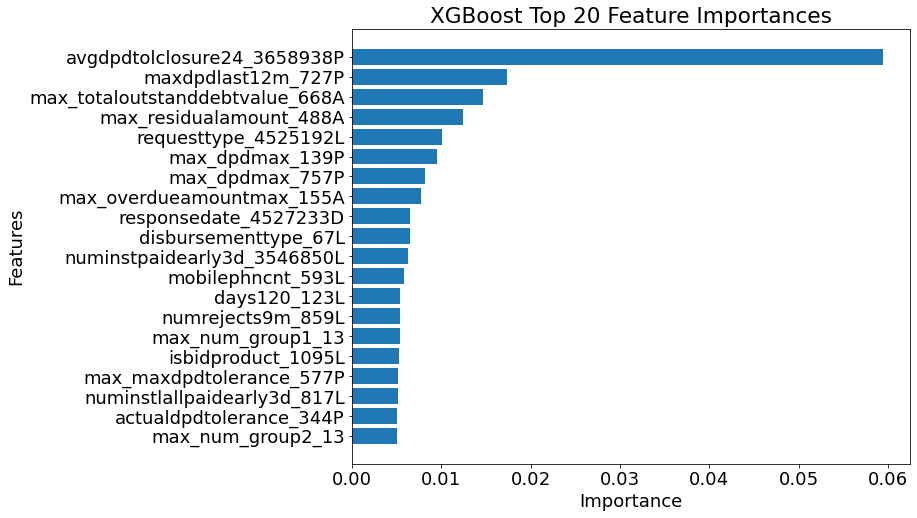

time: 199 ms (started: 2024-04-08 15:06:12 -07:00)


In [125]:
import matplotlib.pyplot as plt
import matplotlib

figure_size=(10,8)

font = {'size': 18}
matplotlib.rc('font', **font)

top_number = 20

df_feature_importance_top_20 = df_feature_importance.head(top_number).sort_values('importance', ascending=True)


fig, ax = plt.subplots(figsize=figure_size)

ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title(f'XGBoost Top {top_number} Feature Importances')


plt.barh(df_feature_importance_top_20.loc[:, 'feature'].head(20), df_feature_importance_top_20.loc[:, 'importance'])
plt.show()



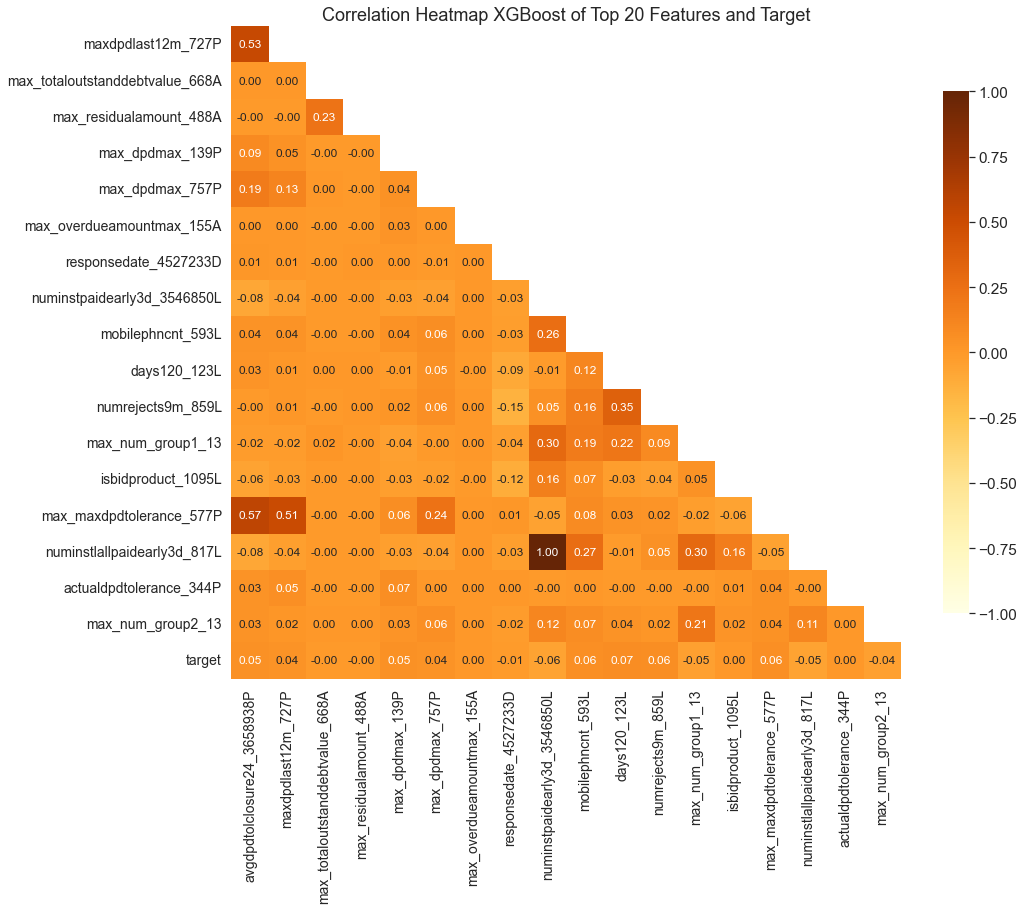

time: 1.55 s (started: 2024-04-08 15:41:38 -07:00)


In [137]:
#correlation heatmap


top_number=20
dpi=100
figure_size=(15, 12)



column_name_list_xgboost_classifier_top_number_by_feature_importance = df_feature_importance.loc[:, 'feature'].head(top_number).to_list()

column_name_list_xgboost_classifier_top_number_by_feature_importance_target = column_name_list_xgboost_classifier_top_number_by_feature_importance + ['target']
del column_name_list_xgboost_classifier_top_number_by_feature_importance




df_feature_correlation = df_train.loc[:, column_name_list_xgboost_classifier_top_number_by_feature_importance_target].corr()

mask = np.triu(np.ones_like(df_feature_correlation, dtype=bool))
mask = mask[1:, :-1]

corr = df_feature_correlation.iloc[1:,:-1].copy()


#plot it
fig, ax = plt.subplots(figsize=figure_size)

sns.set(font_scale=1.4)
sns.set_style("white")

res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)
plt.title('Correlation Heatmap XGBoost of Top '+ str(top_number) +' Features and Target', fontsize=18)

plt.show()

time: 786 µs (started: 2024-04-08 13:32:52 -07:00)


In [ ]:
#Source: https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.feature_importances_




### Training

In [ ]:
# X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
# y = df_train["target"]
# weeks = df_train["WEEK_NUM"]

# cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

# params = {
#     "boosting_type": "gbdt",
#     "objective": "binary",
#     "metric": "auc",
#     "max_depth": 8,
#     "learning_rate": 0.05,
#     "n_estimators": 1000,
#     "colsample_bytree": 0.8, 
#     "colsample_bynode": 0.8,
#     "verbose": -1,
#     "random_state": 42,
#     "device": "gpu",
# }

# fitted_models = []

# for idx_train, idx_valid in cv.split(X, y, groups=weeks):
#     X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
#     X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

#     model = lgb.LGBMClassifier(**params)
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_valid, y_valid)],
#         callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
#     )

#     fitted_models.append(model)

# model = VotingModel(fitted_models)


In [ ]:
help(lgb)

### Prediction

### Submission

### Appendix

In [126]:
import os
import pandas as pd
df_collection={}

#Read in Feature Definitions as a DataFrame
key='feature_definitions'
relative_filename_path=os.path.join("..", "data", "raw", str(key)+".csv")
df_collection[key]=pd.read_csv(relative_filename_path)

#Filter for Select (i.e. 'train_applprev_1_0') features
print(df_collection[key].shape)
df_collection[key]


(465, 2)


,Variable,Description
0,actualdpd_943P,Days Past Due (DPD) of previous contract (actual).
1,actualdpdtolerance_344P,DPD of client with tolerance.
2,addres_district_368M,District of the person's address.
3,addres_role_871L,Role of person's address.
4,addres_zip_823M,Zip code of the address.
5,amount_1115A,Credit amount of the active contract provided by the credit bureau.
6,amount_416A,Deposit amount.
7,amount_4527230A,Tax deductions amount tracked by the government registry.
8,amount_4917619A,Tax deductions amount tracked by the government registry.
9,amtdebitincoming_4809443A,Incoming debit card transactions amount.


time: 52.3 ms (started: 2024-04-08 15:10:25 -07:00)
